Dataset from :-

http://gpcv.whu.edu.cn/data/Bijie_pages.html

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import os, cv2, time, os, torch, itertools, IPython, torchvision, pickle
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.nn.functional  as f
from torchvision import transforms
from tqdm.notebook import tqdm
from torchsummary import summary
from PIL import Image
%matplotlib inline

EPOCHS = 10
BATCH = 128

In [3]:
shp_dict = {}
for i in os.listdir("/content/drive/MyDrive/DLS/project/landslide_data/landslide/image/"):
    i = cv2.imread("/content/drive/MyDrive/DLS/project/landslide_data/landslide/image/"+i)
    if i.shape in shp_dict:
        shp_dict[i.shape]+=1
    else:
        shp_dict[i.shape]=1

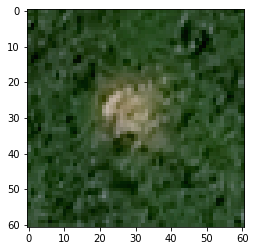

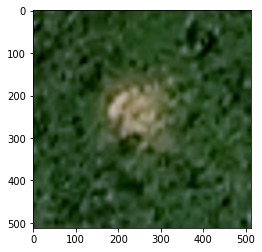

In [4]:
img = Image.open("/content/drive/MyDrive/DLS/project/landslide_data/landslide/image/df004.png")
plt.imshow(img)
plt.show()
img = np.array(img.resize((512, 512)))
plt.imshow(img)
plt.show()

In [5]:
classes = ["landslide", "non-landslide"]

train_df = pd.DataFrame({"images":[],"labels":[]})
for cls in classes:
    images = os.listdir("/content/drive/MyDrive/DLS/project/landslide_data/"+ cls + "/image/")
    for img in range(len(images)):
        images[img] = "/content/drive/MyDrive/DLS/project/landslide_data/"+ cls + "/image/" + images[img]
    temp = pd.DataFrame({"images":images,"labels":[cls]*(len(images))})
    train_df = pd.concat([train_df, temp])

classes_to_int = {cls:i for i,cls in enumerate(classes)}
train_df['labels'] = train_df['labels'].replace(classes_to_int)    

train_df.shape

(2773, 2)

In [6]:
train_df.sample(frac=1).reset_index(drop=True).head()

,images,labels
0,/content/drive/MyDrive/DLS/project/landslide_d...,0
1,/content/drive/MyDrive/DLS/project/landslide_d...,1
2,/content/drive/MyDrive/DLS/project/landslide_d...,1
3,/content/drive/MyDrive/DLS/project/landslide_d...,1
4,/content/drive/MyDrive/DLS/project/landslide_d...,1


In [7]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, dataset, labels, transform=None, target_transform=None):
        self.dataset = dataset
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img = Image.open(self.dataset[index])
        img = np.array(img.resize((512, 512)))
        label = self.labels[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform
        return img, label

train_set = DataSet(train_df['images'].values, train_df['labels'].values)
train_dl = torch.utils.data.DataLoader(train_set, batch_size = BATCH, shuffle = True)

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

train_dl = DeviceDataLoader(train_dl, device)

In [15]:
class Model(torch.nn.Module):
    def __init__(self, n_classes = 7, channels = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, padding = 'same')
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(4, 4, kernel_size=3, padding = 'same')
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(4, 8, kernel_size=3, padding = 'same')
        self.dropout2 = nn.Dropout(0.2)
        self.conv4 = nn.Conv2d(8, 8, kernel_size=3, padding = 'same')
        self.maxpool2 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(8, 16, kernel_size=3, padding = 'same')
        self.dropout3 = nn.Dropout(0.2)
        self.conv6 = nn.Conv2d(16, 16, kernel_size=3, padding = 'same')
        self.maxpool3 = nn.MaxPool2d(2)

        self.conv7 = nn.Conv2d(16, 32, kernel_size=3, padding = 'same')
        self.dropout4 = nn.Dropout(0.2)
        self.conv8 = nn.Conv2d(32, 32, kernel_size=3, padding = 'same')
        self.maxpool4 = nn.MaxPool2d(2)

        self.conv9 = nn.Conv2d(32, 64, kernel_size=3, padding = 'same')
        self.dropout5 = nn.Dropout(0.2)
        self.conv10 = nn.Conv2d(64, 64, kernel_size=3, padding = 'same')

        self.transConv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv11 = nn.Conv2d(64, 32, kernel_size=3, padding = 'same')
        self.dropout6 = nn.Dropout(0.2)
        self.conv12 = nn.Conv2d(32, 32, kernel_size=3, padding = 'same')

        self.transConv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv13 = nn.Conv2d(32, 16, kernel_size=3, padding = 'same')
        self.dropout7 = nn.Dropout(0.2)
        self.conv14 = nn.Conv2d(16, 16, kernel_size=3, padding = 'same')

        self.transConv3 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.conv15 = nn.Conv2d(16, 8, kernel_size=3, padding = 'same')
        self.dropout8 = nn.Dropout(0.2)
        self.conv16 = nn.Conv2d(8, 8, kernel_size=3, padding = 'same')

        self.transConv4 = nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2)
        self.conv17 = nn.Conv2d(8, 4, kernel_size=3, padding = 'same')
        self.dropout9 = nn.Dropout(0.2)
        self.conv18 = nn.Conv2d(4, 4, kernel_size=3, padding = 'same')

        self.final_conv = nn.Conv2d(4, n_classes, kernel_size=1, padding = 'same')

    def forward(self, x):
        """ Encoder """
        x1 = nn.ReLU()(self.conv1(x))
        x1 = self.dropout1(x1)
        x1 = nn.ReLU()(self.conv2(x1))
        p1 = self.maxpool1(x1)

        x2 = nn.ReLU()(self.conv3(p1))
        x2 = self.dropout2(x2)
        x2 = nn.ReLU()(self.conv4(x2))
        p2 = self.maxpool2(x2)

        x3 = nn.ReLU()(self.conv5(p2))
        x3 = self.dropout3(x3)
        x3 = nn.ReLU()(self.conv6(x3))
        p3 = self.maxpool3(x3)

        x4 = nn.ReLU()(self.conv7(p3))
        x4 = self.dropout4(x4)
        x4 = nn.ReLU()(self.conv8(x4))
        p4 = self.maxpool4(x4)

        """Transfer block"""
        x5 = nn.ReLU()(self.conv9(p4))
        x5 = self.dropout5(x5)
        x5 = nn.ReLU()(self.conv10(x5))

        """ Decoder """
        u6 = self.transConv1(x5)
        u6 = torch.cat((u6, x4), 1)
        x6 = nn.ReLU()(self.conv11(u6))
        x6 = self.dropout6(x6)
        x6 = nn.ReLU()(self.conv12(x6))

        u7 = self.transConv2(x6)
        u7 = torch.cat((u7, x3), 1)
        x7 = nn.ReLU()(self.conv13(u7))
        x7 = self.dropout7(x7)
        x7 = nn.ReLU()(self.conv14(x7))

        u8 = self.transConv3(x7)
        u8 = torch.cat((u8, x2), 1)
        x8 = nn.ReLU()(self.conv15(u8))
        x8 = self.dropout8(x8)
        x8 = nn.ReLU()(self.conv16(x8))

        u9 = self.transConv4(x8)
        u9 = torch.cat((u9, x1), 1)
        x9 = nn.ReLU()(self.conv17(u9))
        x9 = self.dropout9(x9)
        x9 = nn.ReLU()(self.conv18(x9))

        '''Classifier'''
        output = self.final_conv(x9)
        return output

# model = Model().to(device)
model = torch.load("model_extend.pt")
for param in model.parameters():
    param.requires_grad = False

In [18]:
criterion = torch.nn.BCEWithLogitsLoss()
class LandslideClassification(torch.nn.Module):
    def __init__(self, pretrained_network = None):
        super().__init__()
        # self.masked_output = pretrained_network
        self.conv2d1 = torch.nn.Conv2d(3, 4, kernel_size=3, stride=2)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2d2 = torch.nn.Conv2d(4, 8, kernel_size=3, stride=2)
        self.dropout2 = nn.Dropout(0.2)
        self.conv2d3 = torch.nn.Conv2d(8, 4, kernel_size=3, stride=2)
        self.dropout3 = nn.Dropout(0.2)
        self.conv2d4 = torch.nn.Conv2d(4, 2, kernel_size=3, stride=2)
        self.dropout4 = nn.Dropout(0.2)
        self.dense1 = torch.nn.Linear(1922, 512)
        self.dense2 = torch.nn.Linear(512, 1)

    def forward(self, x):
        # x = self.masked_output(x)
        
        x = self.conv2d1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        
        x = self.conv2d2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        
        x = self.conv2d3(x)
        x = nn.ReLU()(x)
        x = self.dropout3(x)
        
        x = self.conv2d4(x)
        x = nn.ReLU()(x)
        x = self.dropout4(x)
        
        x = torch.nn.Flatten()(x)
        x = self.dense1(x)
        x = torch.nn.ReLU()(x)

        x = self.dense2(x)
        x = torch.nn.Sigmoid()(x)
        return x

    def trainig_step(self, batch):
        images, labels = batch
        labels = torch.unsqueeze(labels, 1).type(torch.float32)
        images = torch.permute(images, (0, 3, 1, 2)).type(torch.float32)
        preds = torch.round(self(images)).type(torch.float32)
        loss = criterion(self(images).type(torch.float32), labels)
        acc = torch.sum(preds == labels)/len(images)
        return loss, acc
    
baseline = LandslideClassification()
baseline.to(torch.device('cuda'))
summary(baseline, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 255, 255]             112
           Dropout-2          [-1, 4, 255, 255]               0
            Conv2d-3          [-1, 8, 127, 127]             296
           Dropout-4          [-1, 8, 127, 127]               0
            Conv2d-5            [-1, 4, 63, 63]             292
           Dropout-6            [-1, 4, 63, 63]               0
            Conv2d-7            [-1, 2, 31, 31]              74
           Dropout-8            [-1, 2, 31, 31]               0
            Linear-9                  [-1, 512]         984,576
           Linear-10                    [-1, 1]             513
Total params: 985,863
Trainable params: 985,863
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/backward pass size (MB): 6.21
Params size (MB): 3.76
Estimated T

In [19]:
opt = torch.optim.SGD(baseline.parameters(), lr = 0.001)
losses = []
accuracy = []
for i in tqdm(range(EPOCHS)):
    epoch_loss = []
    epoch_acc = []
    for batch in tqdm(train_dl):
        loss, acc = baseline.trainig_step(batch)
        loss.backward()
        opt.step()
        opt.zero_grad() 
        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())
    print(f"Epoch {i} has loss {np.mean(epoch_loss)} with Accuracy {np.mean(epoch_acc)}")
    losses.append(np.mean(epoch_loss))
    accuracy.append(np.mean(epoch_acc))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 0 has loss 0.622608715837652 with Accuracy 0.37383856963027606


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1 has loss 0.6201078512451865 with Accuracy 0.405435327779163


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2 has loss 0.6173042302781885 with Accuracy 0.4665357633070512


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3 has loss 0.6124843088063326 with Accuracy 0.5066719597036188


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4 has loss 0.6119949113238942 with Accuracy 0.5705840587615967


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5 has loss 0.6098271066492255 with Accuracy 0.593858624046499


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 6 has loss 0.6070996793833646 with Accuracy 0.6384316520257429


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 7 has loss 0.6057842509313063 with Accuracy 0.6485503017902374


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 8 has loss 0.6072260737419128 with Accuracy 0.6691385372118517


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 9 has loss 0.601912566206672 with Accuracy 0.7025359300049868


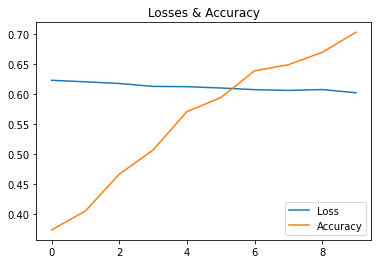

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(losses, label = "Loss")
plt.title("Losses & Accuracy")
plt.plot(accuracy, label = "Accuracy")
plt.legend(loc="lower right")
plt.show()
plt.savefig("cl_model_perf_baseline.png")

In [21]:
criterion = torch.nn.BCEWithLogitsLoss()
class LandslideClassification(torch.nn.Module):
    def __init__(self, pretrained_network = None):
        super().__init__()
        self.masked_output = pretrained_network
        self.conv2d1 = torch.nn.Conv2d(7, 4, kernel_size=3, stride=2)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2d2 = torch.nn.Conv2d(4, 8, kernel_size=3, stride=2)
        self.dropout2 = nn.Dropout(0.2)
        self.conv2d3 = torch.nn.Conv2d(8, 4, kernel_size=3, stride=2)
        self.dropout3 = nn.Dropout(0.2)
        self.conv2d4 = torch.nn.Conv2d(4, 2, kernel_size=3, stride=2)
        self.dropout4 = nn.Dropout(0.2)
        self.dense1 = torch.nn.Linear(1922, 512)
        self.dense2 = torch.nn.Linear(512, 1)

    def forward(self, x):
        x = self.masked_output(x)
        
        x = self.conv2d1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        
        x = self.conv2d2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        
        x = self.conv2d3(x)
        x = nn.ReLU()(x)
        x = self.dropout3(x)
        
        x = self.conv2d4(x)
        x = nn.ReLU()(x)
        x = self.dropout4(x)
        
        x = torch.nn.Flatten()(x)
        x = self.dense1(x)
        x = torch.nn.ReLU()(x)

        x = self.dense2(x)
        x = torch.nn.Sigmoid()(x)
        return x

    def trainig_step(self, batch):
        images, labels = batch
        labels = torch.unsqueeze(labels, 1).type(torch.float32)
        images = torch.permute(images, (0, 3, 1, 2)).type(torch.float32)
        preds = torch.round(self(images)).type(torch.float32)
        loss = criterion(self(images).type(torch.float32), labels)
        acc = torch.sum(preds == labels)/len(images)
        return loss, acc
    
classify = LandslideClassification(model)
classify.to(torch.device('cuda'))
summary(classify, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 512, 512]             112
           Dropout-2          [-1, 4, 512, 512]               0
            Conv2d-3          [-1, 4, 512, 512]             148
         MaxPool2d-4          [-1, 4, 256, 256]               0
            Conv2d-5          [-1, 8, 256, 256]             296
           Dropout-6          [-1, 8, 256, 256]               0
            Conv2d-7          [-1, 8, 256, 256]             584
         MaxPool2d-8          [-1, 8, 128, 128]               0
            Conv2d-9         [-1, 16, 128, 128]           1,168
          Dropout-10         [-1, 16, 128, 128]               0
           Conv2d-11         [-1, 16, 128, 128]           2,320
        MaxPool2d-12           [-1, 16, 64, 64]               0
           Conv2d-13           [-1, 32, 64, 64]           4,640
          Dropout-14           [-1, 32,

In [22]:
opt = torch.optim.SGD(classify.parameters(), lr = 0.001)
losses_final = []
accuracy_final = []
for i in tqdm(range(EPOCHS)):
    epoch_loss = []
    epoch_acc = []
    for batch in tqdm(train_dl):
        loss, acc = classify.trainig_step(batch)
        loss.backward()
        opt.step()
        opt.zero_grad() 
        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())
    print(f"Epoch {i} has loss {np.mean(epoch_loss)} with Accuracy {np.mean(epoch_acc)}")
    losses_final.append(np.mean(epoch_loss))
    accuracy_final.append(np.mean(epoch_acc))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 0 has loss 0.5950750356370752 with Accuracy 0.6876169795339758


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1 has loss 0.5890521244569258 with Accuracy 0.7138995663686232


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2 has loss 0.5875824012539603 with Accuracy 0.7101687843149359


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3 has loss 0.5879277153448625 with Accuracy 0.712662935256958


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4 has loss 0.5872493088245392 with Accuracy 0.7163686508482153


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5 has loss 0.5834823955189098 with Accuracy 0.718185996467417


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 6 has loss 0.5850198837843809 with Accuracy 0.7179896398024126


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 7 has loss 0.5855112048712644 with Accuracy 0.720667614178224


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 8 has loss 0.5866240506822412 with Accuracy 0.7145972604101355


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 9 has loss 0.5861986442045732 with Accuracy 0.7195813845504414


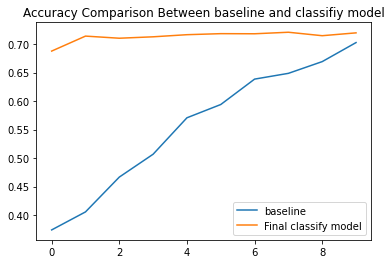

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(accuracy, label = "baseline")
plt.title("Accuracy Comparison Between baseline and classifiy model")
plt.plot(accuracy_final, label = "Final classify model")
plt.legend(loc="lower right")
plt.show()
plt.savefig("acc_comp.png")

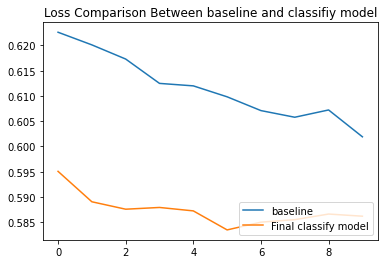

<Figure size 432x288 with 0 Axes>

In [24]:
plt.plot(losses, label = "baseline")
plt.title("Loss Comparison Between baseline and classifiy model")
plt.plot(losses_final, label = "Final classify model")
plt.legend(loc="lower right")
plt.show()
plt.savefig("loss_comp.png")